In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# sample
idx = np.random.choice(np.arange(len(trainset)), size=1000)
trainset = [trainset[i] for i in idx]
idx = np.random.choice(np.arange(len(testset)), size=1000)
testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 1, 28, 28]),
 torch.Size([1000]),
 torch.Size([1000]))

# umap + emb

In [8]:
import umap

time_cost = []

for n in [5, 10, 20, 50, 100, 200]:
    
    for min_dist in [0.03, 0.1, 0.25, 0.5, 0.8, 0.99]:

        t1 = time.time()
        reducer = umap.UMAP(n_neighbors=n, min_dist=min_dist, n_components=2, metric='euclidean')
        emb = reducer.fit_transform(X_train.view(-1, 28*28))
        t2 = time.time()
        print("n_neighbors: {}, min_dist:{}, time: {}".format(n, min_dist, t2-t1))
        time_cost.append(t2-t1)

        draw_z(
            z=normalise(emb), 
            cls=y_train, 
            s=1, 
            title="n: {}, min_dist: {}, time: {}".format(n, min_dist, t2-t1), 
            display=False, 
            save_path="./data/facts_check/vis_umapemb_n{}_mindist{}.png".format(n, min_dist)
        )

n_neighbors: 5, min_dist:0.03, time: 2.309999704360962
n_neighbors: 5, min_dist:0.1, time: 2.2879889011383057
n_neighbors: 5, min_dist:0.25, time: 2.6669931411743164
n_neighbors: 5, min_dist:0.5, time: 2.2809908390045166
n_neighbors: 5, min_dist:0.8, time: 2.2739901542663574
n_neighbors: 5, min_dist:0.99, time: 2.287997007369995
n_neighbors: 10, min_dist:0.03, time: 2.901000738143921
n_neighbors: 10, min_dist:0.1, time: 2.440992593765259
n_neighbors: 10, min_dist:0.25, time: 2.402992010116577
n_neighbors: 10, min_dist:0.5, time: 2.825998306274414
n_neighbors: 10, min_dist:0.8, time: 2.397998571395874
n_neighbors: 10, min_dist:0.99, time: 2.4529964923858643
n_neighbors: 20, min_dist:0.03, time: 2.557995557785034
n_neighbors: 20, min_dist:0.1, time: 2.957990884780884
n_neighbors: 20, min_dist:0.25, time: 2.5889925956726074
n_neighbors: 20, min_dist:0.5, time: 2.5638492107391357
n_neighbors: 20, min_dist:0.8, time: 2.8739993572235107
n_neighbors: 20, min_dist:0.99, time: 2.539990901947021

d:\anaconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


n_neighbors: 50, min_dist:0.25, time: 3.2139925956726074


d:\DV_HL\utils.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=1500)


n_neighbors: 50, min_dist:0.5, time: 2.801990270614624
n_neighbors: 50, min_dist:0.8, time: 2.797992467880249
n_neighbors: 50, min_dist:0.99, time: 2.834996461868286
n_neighbors: 100, min_dist:0.03, time: 3.3759913444519043
n_neighbors: 100, min_dist:0.1, time: 2.984992265701294
n_neighbors: 100, min_dist:0.25, time: 3.0069992542266846
n_neighbors: 100, min_dist:0.5, time: 2.9509918689727783
n_neighbors: 100, min_dist:0.8, time: 3.3719921112060547
n_neighbors: 100, min_dist:0.99, time: 3.0249969959259033
n_neighbors: 200, min_dist:0.03, time: 3.2029902935028076
n_neighbors: 200, min_dist:0.1, time: 3.590991973876953
n_neighbors: 200, min_dist:0.25, time: 3.152992010116577
n_neighbors: 200, min_dist:0.5, time: 3.43599009513855
n_neighbors: 200, min_dist:0.8, time: 3.184990406036377
n_neighbors: 200, min_dist:0.99, time: 3.5589921474456787


In [67]:
import umap

time_cost = []

for n in [20]:
    
    for min_dist in [0.1]:

        t1 = time.time()
        reducer = umap.UMAP(n_neighbors=n, min_dist=min_dist, n_components=2, metric='euclidean', init='random', dens_frac=0)
        emb = reducer.fit_transform(X_train.view(-1, 28*28))
        t2 = time.time()
        print("n_neighbors: {}, min_dist:{}, time: {}".format(n, min_dist, t2-t1))
        time_cost.append(t2-t1)

        draw_z(
            z=normalise(emb), 
            cls=y_train, 
            s=1, 
            title="n: {}, min_dist: {}, time: {}".format(n, min_dist, t2-t1), 
            display=False, 
            save_path="./data/facts_check/vis_umapemb_n{}_mindist{}_random_10k_densfrac0.png".format(n, min_dist)
        )

n_neighbors: 20, min_dist:0.1, time: 8.131998777389526


# umap + nn

### umap - github

In [3]:
# for n in [5, 10, 20, 50, 100, 200]:
# for n in [50, 100, 200]:
    
#     for min_dist in [0.03, 0.1, 0.25, 0.5, 0.8, 0.99]:

for n in [5]:
    for min_dist in [0.03, 0.1, 0.25, 0.5, 0.8, 0.99]:

        print("n_neighbours: {}, min_dist: {}".format(n, min_dist))

        # 1. dataset
        batch_size = 1000 # 1024

        # construct graph of nearest neighbors
        graph_constructor_train =  ConstructUMAPGraph(metric='euclidean', n_neighbors=n, batch_size=1000, random_state=42)
        epochs_per_sample_train, head_train, tail_train, weight_train = graph_constructor_train(X_train)

        graph_constructor_test =  ConstructUMAPGraph(metric='euclidean', n_neighbors=n, batch_size=1000, random_state=42)
        epochs_per_sample_test, head_test, tail_test, weight_test = graph_constructor_test(X_test)

        train_dataset = UMAPDataset(
            data=X_train, labels=y_train, 
            epochs_per_sample=epochs_per_sample_train, head=head_train, tail=tail_train, weight=weight_train, 
            device='cuda', batch_size=batch_size, feedback=None
        )
        test_dataset = UMAPDataset(
            data=X_test, labels=y_test, 
            epochs_per_sample=epochs_per_sample_test, head=head_test, tail=tail_test, weight=weight_test, 
            device='cuda', batch_size=batch_size, feedback=None
        )

        criterion = UMAPLoss(device='cuda', min_dist=min_dist, batch_size=batch_size, negative_sample_rate=5, edge_weight=None, repulsion_strength=1.0)

        # 2. model
        class Encoder(nn.Module):

            def __init__ (self, output_dim=2):
                super().__init__()
                self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2)
                self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
                self.flatten = nn.Flatten()
                self.linear1 = nn.Linear(128*6*6, 512)
                self.linear2 = nn.Linear(512, 512)
                self.linear3 = nn.Linear(512, output_dim)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = self.flatten(x)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))

                return x

        model = Encoder(output_dim=2).cuda()
        # print(model)
        # print("num params: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

        # 3. training
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        train_losses = []
        for epoch in tqdm(range(20)):
            # 100 epoch - n_neighbour<50 10min; >50 40min
            train_loss = 0.
            # for batch_to, batch_from in tqdm(train_dataset.get_batches()):
            for batch_to, batch_from, batch_index_to, batch_index_from, labels, feedback in train_dataset.get_batches():
                optimizer.zero_grad()
                embedding_to = model(batch_to)
                embedding_from = model(batch_from)
                loss = criterion(embedding_to, embedding_from)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

            train_losses.append(train_loss)
            # print('epoch: {}, loss: {}'.format(epoch, train_loss))

        torch.save(model.state_dict(), './data/facts_check/umap_n{}_dist{}.pt'.format(n, min_dist))
        torch.save(torch.tensor(train_losses), './data/facts_check/loss_umap_n{}_dist{}.pt'.format(n, min_dist))

n_neighbours: 5, min_dist: 0.03
Wed Nov 29 00:13:36 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:40 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	Stopping threshold met -- exiting after 4 iterations
Wed Nov 29 00:13:51 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:51 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	 6  /  10
	Stopping threshold met -- exiting after 6 iterations


100%|██████████| 20/20 [00:01<00:00, 18.00it/s]


n_neighbours: 5, min_dist: 0.1
Wed Nov 29 00:13:52 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:52 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations
Wed Nov 29 00:13:52 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:52 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations


100%|██████████| 20/20 [00:00<00:00, 26.99it/s]


n_neighbours: 5, min_dist: 0.25
Wed Nov 29 00:13:53 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:53 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations
Wed Nov 29 00:13:53 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:53 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	Stopping threshold met -- exiting after 4 iterations


100%|██████████| 20/20 [00:00<00:00, 25.38it/s]


n_neighbours: 5, min_dist: 0.5
Wed Nov 29 00:13:54 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:54 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	Stopping threshold met -- exiting after 4 iterations
Wed Nov 29 00:13:54 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:54 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations


100%|██████████| 20/20 [00:00<00:00, 25.00it/s]


n_neighbours: 5, min_dist: 0.8
Wed Nov 29 00:13:55 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:55 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations
Wed Nov 29 00:13:55 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:55 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


n_neighbours: 5, min_dist: 0.99
Wed Nov 29 00:13:56 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:56 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations
Wed Nov 29 00:13:56 2023 Building RP forest with 7 trees
Wed Nov 29 00:13:56 2023 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations


100%|██████████| 20/20 [00:00<00:00, 25.13it/s]


In [6]:
all_models

['./data/facts_check\\umap_n5_dist0.03.pt',
 './data/facts_check\\umap_n5_dist0.1.pt',
 './data/facts_check\\umap_n5_dist0.25.pt',
 './data/facts_check\\umap_n5_dist0.5.pt',
 './data/facts_check\\umap_n5_dist0.8.pt',
 './data/facts_check\\umap_n5_dist0.99.pt']

In [18]:
import glob

# all_models = glob.glob("./data/facts_check/umap*.pt")
# all_models = glob.glob("./data/facts_check/umap_n5_dist*.pt")
all_models = ["./data/facts_check\\umap_n5_dist0.8.pt"]

# for i in tqdm(range(len(all_models))):

model.load_state_dict(torch.load(all_models[i]))

model.eval()

emb = model(X_train.cuda())

title = all_models[i].split("\\")[-1][:-3]

draw_z(
    z=normalise(emb.detach().cpu()), 
    cls=y_train, 
    s=1, 
    title=title, 
    save_path="./data/facts_check/vis_{}.png".format(title), 
    display=True)

<Figure size 9600x7200 with 0 Axes>

In [19]:
emb

tensor([[ 0.0000, 24.6706],
        [ 0.0000, 40.7593],
        [ 0.0000, 45.6523],
        ...,
        [ 0.0000, 24.3131],
        [ 0.0000, 34.4304],
        [ 0.0000, 27.7081]], device='cuda:0', grad_fn=<ReluBackward0>)

In [17]:
title

'umap_n5_dist0.8'

In [7]:
"./data/facts_check/vis_{}.png".format(title)

'./data/facts_check/vis_umap_n5_dist0.99.png'

In [51]:
all_models[0].split("\\")[-1][:-3]

'umap_n100_dist0.03'

In [50]:
all_models

['./data/facts_check\\umap_n100_dist0.03.pt',
 './data/facts_check\\umap_n100_dist0.1.pt',
 './data/facts_check\\umap_n10_dist0.03.pt',
 './data/facts_check\\umap_n10_dist0.1.pt',
 './data/facts_check\\umap_n10_dist0.25.pt',
 './data/facts_check\\umap_n10_dist0.5.pt',
 './data/facts_check\\umap_n10_dist0.8.pt',
 './data/facts_check\\umap_n10_dist0.99.pt',
 './data/facts_check\\umap_n20_dist0.03.pt',
 './data/facts_check\\umap_n20_dist0.1.pt',
 './data/facts_check\\umap_n20_dist0.25.pt',
 './data/facts_check\\umap_n20_dist0.5.pt',
 './data/facts_check\\umap_n20_dist0.8.pt',
 './data/facts_check\\umap_n20_dist0.99.pt',
 './data/facts_check\\umap_n50_dist0.03.pt',
 './data/facts_check\\umap_n50_dist0.1.pt',
 './data/facts_check\\umap_n50_dist0.25.pt',
 './data/facts_check\\umap_n50_dist0.5.pt',
 './data/facts_check\\umap_n50_dist0.8.pt',
 './data/facts_check\\umap_n50_dist0.99.pt',
 './data/facts_check\\umap_n5_dist0.03.pt',
 './data/facts_check\\umap_n5_dist0.1.pt',
 './data/facts_check\

### umap - github 60k

In [5]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# # sample
# idx = np.random.choice(np.arange(len(trainset)), size=1000)
# trainset = [trainset[i] for i in idx]
# idx = np.random.choice(np.arange(len(testset)), size=1000)
# testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

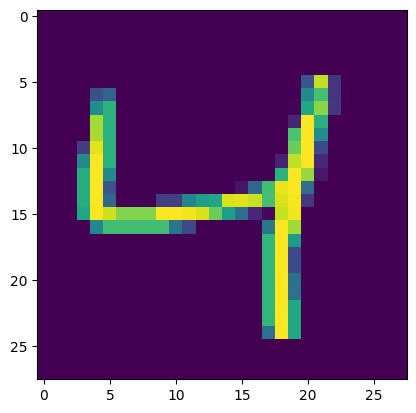

In [56]:
plt.imshow(X_train[2][0])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Encoder(output_dim=2).to(device)
print(model)
print("num params: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
)
num params: 2697986


In [9]:
for n in [20]:
    
    for min_dist in [0.1]:

        print("n_neighbours: {}, min_dist: {}".format(n, min_dist))

        # 1. dataset
        batch_size = 1000 # 1024

        # construct graph of nearest neighbors
        graph_constructor_train =  ConstructUMAPGraph(metric='euclidean', n_neighbors=n, batch_size=1000, random_state=42)
        epochs_per_sample_train, head_train, tail_train, weight_train = graph_constructor_train(X_train)

        graph_constructor_test =  ConstructUMAPGraph(metric='euclidean', n_neighbors=n, batch_size=1000, random_state=42)
        epochs_per_sample_test, head_test, tail_test, weight_test = graph_constructor_test(X_test)

        train_dataset = UMAPDataset(
            data=X_train, labels=y_train, 
            epochs_per_sample=epochs_per_sample_train, head=head_train, tail=tail_train, weight=weight_train, 
            device='cuda', batch_size=batch_size, feedback=None
        )
        test_dataset = UMAPDataset(
            data=X_test, labels=y_test, 
            epochs_per_sample=epochs_per_sample_test, head=head_test, tail=tail_test, weight=weight_test, 
            device='cuda', batch_size=batch_size, feedback=None
        )

        criterion = UMAPLoss(device='cuda', min_dist=min_dist, batch_size=batch_size, negative_sample_rate=5, edge_weight=None, repulsion_strength=1.0)

        # 2. model
        

        # 3. training
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        train_losses = []
        for epoch in tqdm(range(100)):
            train_loss = 0.
            # for batch_to, batch_from in tqdm(train_dataset.get_batches()):
            for batch_to, batch_from, batch_index_to, batch_index_from, labels, feedback in train_dataset.get_batches():
                optimizer.zero_grad()
                embedding_to = model(batch_to.to(device))
                embedding_from = model(batch_from.to(device))
                loss = criterion(embedding_to, embedding_from)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

            train_losses.append(train_loss)
            # print('epoch: {}, loss: {}'.format(epoch, train_loss))

        torch.save(model.state_dict(), './data/facts_check/umap_n{}_dist{}.pt'.format(n, min_dist))
        torch.save(torch.tensor(train_losses), './data/facts_check/loss_umap_n{}_dist{}.pt'.format(n, min_dist))

n_neighbours: 20, min_dist: 0.1
Tue Nov 28 22:17:22 2023 Building RP forest with 17 trees
Tue Nov 28 22:17:27 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Nov 28 22:17:41 2023 Building RP forest with 10 trees
Tue Nov 28 22:17:41 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


  1%|          | 1/100 [01:12<1:59:25, 72.38s/it]


KeyboardInterrupt: 

In [12]:
for batch_to, batch_from, batch_index_to, batch_index_from, labels, feedback in train_dataset.get_batches():
    break

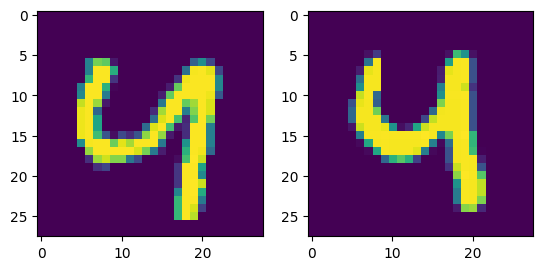

In [51]:
i = 789

plt.subplot(1,2,1)
plt.imshow(batch_from[i][0].detach().cpu())

plt.subplot(1,2,2)
plt.imshow(batch_to[i][0].detach().cpu())

plt.show()

In [53]:
embedding_to.shape, embedding_from.shape

(torch.Size([1000, 2]), torch.Size([1000, 2]))

In [ ]:
train_dataset.batches_per_epoch

1211

In [ ]:
plt.plot(train_losses/train_dataset.batches_per_epoch)
plt.show()

In [64]:
train_losses = torch.load("./data/facts_check/loss_umap_n20_dist0.1.pt")
plt.plot(train_losses/train_dataset.batches_per_epoch)
plt.show()